In [5]:
import random
import math
import matplotlib.pyplot as plt
import numpy as np

# Part 1

Implementing M/M/1 queue

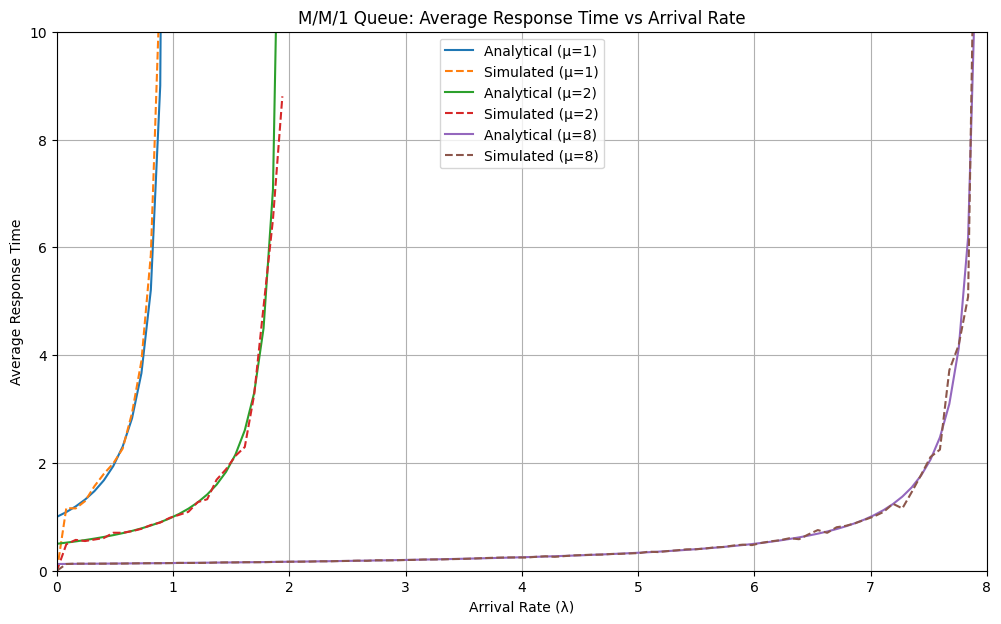

In [6]:
class MM1Queue:
    def __init__(self, arrival_rate, service_rate, simulation_time):
        """
        Initializes an M/M/1 queue simulator.

        Parameters:
        arrival_rate: (λ).
        service_rate: (μ).
        simulation_time: The total time the simulation will run.

        Attributes:
        self.queue (list): A list to hold the arrival times of customers currently in the queue.
        self.total_response_time: The accumulated total response time of all served customers.
        self.total_customers: The total number of customers that have been served.
        self.current_time: The current time in the simulation.
        """
        self.arrival_rate = arrival_rate
        self.service_rate = service_rate
        self.simulation_time = simulation_time

        self.queue = []
        self.total_response_time = 0
        self.total_customers = 0
        self.current_time = 0

    def generate_interarrival_time(self):
        """
        Returns:
        The time until the next arrival, following an exponential distribution.
        """
        return random.expovariate(self.arrival_rate) if self.arrival_rate > 0 else float('inf')

    def generate_service_time(self):
        """
        Returns:
        The service time, following an exponential distribution.
        """
        return random.expovariate(self.service_rate)

    def simulate(self):
        """
        Runs the simulation of the M/M/1 queue.

        Returns:
        The average response time of customers served during the simulation.
        """
        next_arrival = self.generate_interarrival_time()  # Time until the next arrival
        next_departure = float('inf')                      # Time until the next departure

        while self.current_time < self.simulation_time:
            if next_arrival < next_departure:  # If the next arrival occurs before the next departure
                self.current_time = next_arrival  # Update current time to next arrival
                self.queue.append(self.current_time)  # Add arrival time to the queue
                next_arrival = self.current_time + self.generate_interarrival_time()  # Schedule next arrival

                if len(self.queue) == 1:  # If this is the first customer in the queue
                    next_departure = self.current_time + self.generate_service_time()  # Schedule departure
            else:  # If the next departure occurs before the next arrival
                self.current_time = next_departure  # Update current time to next departure
                if len(self.queue) > 0:  # If there are customers in the queue
                    arrival_time = self.queue.pop(0)  # Remove the first customer from the queue
                    self.total_response_time += self.current_time - arrival_time  # Calculate response time
                    self.total_customers += 1  # Increment the number of customers served

                    if len(self.queue) > 0:  # If there are more customers waiting
                        next_departure = self.current_time + self.generate_service_time()  # Schedule next departure
                    else:
                        next_departure = float('inf')  # No customers left, set next departure to infinity
                else:
                    next_departure = float('inf')  # No customers to serve, set next departure to infinity

        # Return the average response time, or 0 if no customers were served
        return self.total_response_time / self.total_customers if self.total_customers > 0 else 0

def analytical_response_time(arrival_rate, service_rate):
    """
    Calculates the analytical average response time for an M/M/1 queue.

    Parameters:
    arrival_rate: (λ).
    service_rate: (μ).

    Returns:
    The average response time, or infinity if the system is unstable.
    """
    rho = arrival_rate / service_rate
    if rho >= 1:
        return float('inf')  # System is unstable
    return 1 / (service_rate - arrival_rate)

def plot_response_times(mu_values):
    """
    Plots the average response times for both analytical and simulated M/M/1 queues.

    Parameters:
    mu_values: A list of service rates (μ) to simulate and analyze.
    """
    lambda_values = np.linspace(0, max(mu_values), 100)  # Generate a range of arrival rates

    plt.figure(figsize=(12, 7))

    for mu in mu_values:
        analytical_times = [analytical_response_time(lam, mu) for lam in lambda_values]  # Calculate analytical times
        simulated_times = []

        for lam in lambda_values:
            if lam < mu:  # Only simulate for stable conditions
                queue = MM1Queue(lam, mu, 10000)
                simulated_times.append(queue.simulate())  # Run the simulation and store the result
            else:
                simulated_times.append(float('inf'))  # Unstable condition

        plt.plot(lambda_values, analytical_times, label=f'Analytical (μ={mu})', linestyle='-')
        plt.plot(lambda_values, simulated_times, label=f'Simulated (μ={mu})', linestyle='--')

    plt.xlabel('Arrival Rate (λ)')
    plt.ylabel('Average Response Time')
    plt.title('M/M/1 Queue: Average Response Time vs Arrival Rate')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 10)
    plt.xlim(0, max(mu_values))
    plt.show()


plot_response_times([1, 2, 8])

## Notes:

* The simulated results closely match the analytical calculations and Small discrepancies are expected due to the randomness in the simulation and finite simulation time.

* For μ = 1, the system becomes unstable (infinite queue) as λ approaches 1.
* For μ = 2, the system can handle higher arrival rates before becoming unstable.
* For μ = 8, the system remains stable for a much wider range of arrival rates.

* As λ approaches μ, the average response time increases rapidly.
* When λ < μ, the system is stable, and response times are finite.
* When λ ≥ μ, the system becomes unstable, leading to infinite response times.





# Part 2

Implementing M/G/1 queue

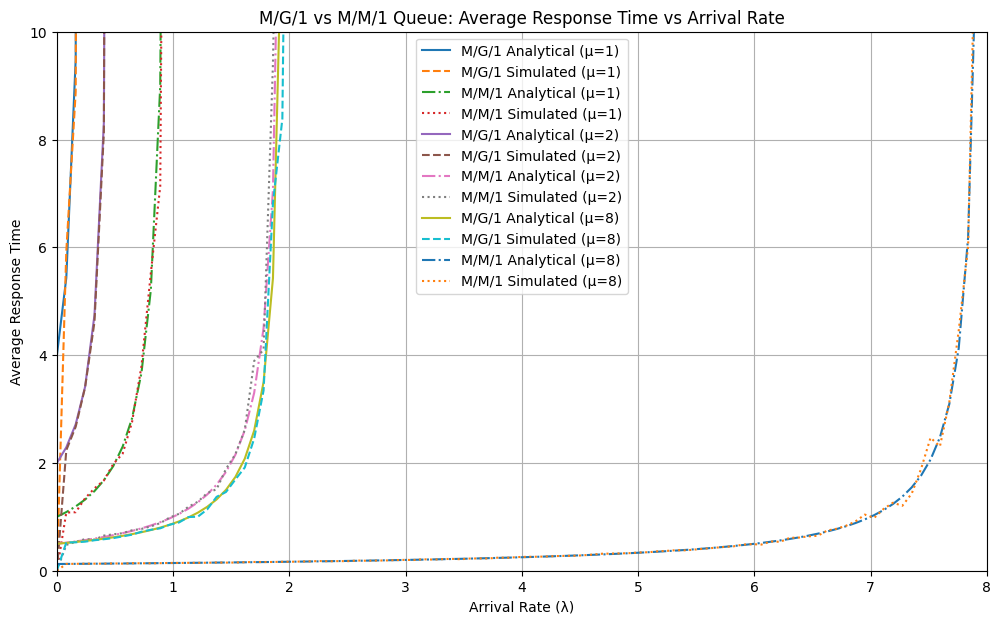

In [13]:
class MG1Queue:
    def __init__(self, arrival_rate, service_rate, simulation_time):
        """
        Initializes an M/G/1 queue simulator.

        Parameters:
        arrival_rate: (λ).
        service_rate: (μ).
        simulation_time: The total time for which the simulation will run.

        Attributes:
        self.queue: A list to hold the arrival times of customers currently in the queue.
        self.total_response_time: The accumulated total response time of all served customers.
        self.total_customers: The total number of customers that have been served.
        self.current_time: The current time in the simulation.
        """
        self.arrival_rate = arrival_rate
        self.service_rate = service_rate
        self.simulation_time = simulation_time

        self.queue = []
        self.total_response_time = 0
        self.total_customers = 0
        self.current_time = 0

    def generate_interarrival_time(self):
        """
        Generates the time until the next customer arrives.

        Returns:
        The time until the next arrival, following an exponential distribution.
        """
        return random.expovariate(self.arrival_rate) if self.arrival_rate > 0 else float('inf')

    def generate_service_time(self):
        """
        Generates the service time for a customer using Erlang-2 distribution.

        Returns:
        The total service time, which is the sum of two exponentially distributed service times.
        """
        # Erlang-2 distribution with parameter μ/2
        return sum(random.expovariate(self.service_rate / 2) for _ in range(2))

    def simulate(self):
        """
        Runs the simulation of the M/G/1 queue.

        Returns:
        The average response time of customers served during the simulation.
        """
        next_arrival = self.generate_interarrival_time()
        next_departure = float('inf')

        while self.current_time < self.simulation_time:
            if next_arrival < next_departure:  # If the next arrival occurs before the next departure
                self.current_time = next_arrival  # Update current time to next arrival
                self.queue.append(self.current_time)  # Add arrival time to the queue
                next_arrival = self.current_time + self.generate_interarrival_time()  # Schedule next arrival

                if len(self.queue) == 1:  # If this is the first customer in the queue
                    next_departure = self.current_time + self.generate_service_time()  # Schedule departure
            else:  # If the next departure occurs before the next arrival
                self.current_time = next_departure  # Update current time to next departure
                if self.queue:  # If there are customers in the queue
                    arrival_time = self.queue.pop(0)  # Remove the first customer from the queue
                    self.total_response_time += self.current_time - arrival_time  # Calculate response time
                    self.total_customers += 1  # Increment the number of customers served

                    if len(self.queue) > 0:  # If there are more customers waiting
                        next_departure = self.current_time + self.generate_service_time()  # Schedule next departure
                    else:
                        next_departure = float('inf')  # No customers left, set next departure to infinity
                else:
                    next_departure = float('inf')  # No customers to serve, set next departure to infinity

        # Return the average response time, or 0 if no customers were served
        return self.total_response_time / self.total_customers if self.total_customers > 0 else 0

class MM1Queue(MG1Queue):
    def generate_service_time(self):
        """
        Generates the service time for a customer using exponential distribution.

        Returns:
        The service time, following an exponential distribution.
        """
        return random.expovariate(self.service_rate)

def analytical_mg1_response_time(arrival_rate, service_rate):
    """
    Calculates the analytical average response time for an M/G/1 queue.

    Returns:
    The average response time, or infinity if the system is unstable.
    """
    rho = arrival_rate / (service_rate / 4)
    if rho >= 1:
        return float('inf')  # System is unstable
    E_S = 2 * (1 / (service_rate / 2))
    Var_S = 2 / (service_rate / 2) ** 2
    E_S2 = Var_S + E_S ** 2
    E_T = E_S + ((arrival_rate * E_S2) / (2 * (1 - rho)))
    return E_T

def analytical_mm1_response_time(arrival_rate, service_rate):
    """
    Calculates the analytical average response time for an M/M/1 queue.

    Returns:
    The average response time, or infinity if the system is unstable.
    """
    rho = arrival_rate / service_rate
    if rho >= 1:
        return float('inf')  # System is unstable
    return 1 / (service_rate - arrival_rate)

def plot_response_times(mu_values):
    """
    Plots the average response times for both analytical and simulated M/G/1 and M/M/1 queues.

    Parameters:
    mu_values: A list of service rates (μ) to simulate and analyze.
    """
    lambda_values = np.linspace(0, max(mu_values), 100)  # Generate a range of arrival rates

    plt.figure(figsize=(12, 7))

    for mu in mu_values:
        # Calculate analytical response times for M/G/1 and M/M/1 queues
        mg1_analytical = [analytical_mg1_response_time(lam, mu) for lam in lambda_values]
        mm1_analytical = [analytical_mm1_response_time(lam, mu) for lam in lambda_values]
        mg1_simulated = []
        mm1_simulated = []

        for lam in lambda_values:
            if lam < mu:  # Only simulate for stable conditions
                mg1_queue = MG1Queue(lam, mu, 10000)
                mm1_queue = MM1Queue(lam, mu, 10000)
                mg1_simulated.append(mg1_queue.simulate())  # Run the simulation and store the result
                mm1_simulated.append(mm1_queue.simulate())
            else:
                mg1_simulated.append(float('inf'))  # Unstable condition for M/G/1
                mm1_simulated.append(float('inf'))  # Unstable condition for M/M/1

        # Plot analytical and simulated response times for both queues
        plt.plot(lambda_values, mg1_analytical, label=f'M/G/1 Analytical (μ={mu})', linestyle='-')
        plt.plot(lambda_values, mg1_simulated, label=f'M/G/1 Simulated (μ={mu})', linestyle='--')
        plt.plot(lambda_values, mm1_analytical, label=f'M/M/1 Analytical (μ={mu})', linestyle='-.')
        plt.plot(lambda_values, mm1_simulated, label=f'M/M/1 Simulated (μ={mu})', linestyle=':')

    plt.xlabel('Arrival Rate (λ)')
    plt.ylabel('Average Response Time')
    plt.title('M/G/1 vs M/M/1 Queue: Average Response Time vs Arrival Rate')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 10)
    plt.xlim(0, max(mu_values))
    plt.show()

# Run simulation and plot results
plot_response_times([1, 2, 8])

## Notes

* The M/G/1 queue with Erlang-2 service time generally has higher average response times compared to the M/M/1 queue.
* For μ = 1, both queues become unstable as λ approaches 1, but M/G/1 shows higher response times.
* For μ = 2 and μ = 8, the difference between M/G/1 and M/M/1 is more pronounced at higher arrival rates.
* Both queues become unstable as λ approaches μ, but M/G/1 shows a steeper increase in response time near the stability threshold.
* Higher service rates (μ) result in lower average response times for both queue types, with M/M/1 consistently outperforming M/G/1.
* The M/G/1 queue consistently shows higher average response times due to the increased variability in service times.

